In [83]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", False)
from sklearn.metrics import mean_absolute_percentage_error
from datetime import date, timedelta, datetime
from sklearn.metrics import r2_score

# Prepare dataset

## Load data

In [84]:
df = pd.read_csv('data/data_preparation.csv', index_col=[0])
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)

### Select relevant features

In [85]:
df.drop(columns=['t - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 't - 8', 't - 9', 't - 10', 't - 11', 't - 12',
       't - 13', 't - 14', 't - 15', 't - 16', 't - 17', 't - 18', 't - 19',
       't - 20', 't - 21', 't - 22', 't - 23', 't - 24', 't - 25', 't - 26',
       't - 27', 't - 28', 't - 29', 't - 30','sin365_1', 'cos365_1', 'sin365_2', 'cos365_2',
       'sin365_3', 'cos365_3','bank_holiday', 'school_holidays',
       'season','Thermique (MW)', 'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)',
       'Hydraulique (MW)', 'Pompage (MW)', 'Bioénergies (MW)',
       'Ech. physiques (MW)', 'Stockage batterie', 'Déstockage batterie',
       'Eolien terrestre', 'Eolien offshore', 'TCO Thermique (%)',
       'TCH Thermique (%)', 'TCO Nucléaire (%)', 'TCH Nucléaire (%)',
       'TCO Eolien (%)', 'TCH Eolien (%)', 'TCO Solaire (%)',
       'TCH Solaire (%)', 'Column 30','Code INSEE région','sin_month', 'cos_month',
        'num_day',
        'YEAR', 'MONTH', 'DAY',
        'T2MDEW', 'T2MWET', 'TS', 'T2M_RANGE',
       'T2M_MAX', 'T2M_MIN','PS', 'QV2M','WS10M','WS50M','RH2M','week_day' #temoin
        #'PRECTOTCORR' # PRECTOTCORR is bias-corrected total precipitation
        #'sin_day','cos_day'
                ],inplace=True)

### Look of the dataset

In [86]:
df

,Consommation (MW),T2M,PRECTOTCORR,sin_day,cos_day
Date,,,,,
2013-02-02,262321.0,5.55,1.94,-0.974928,-0.222521
2013-02-03,273743.0,2.96,0.02,-0.781831,0.623490
2013-02-04,295369.0,4.67,0.00,0.000000,1.000000
2013-02-05,287424.0,6.65,0.19,0.781831,0.623490
2013-02-06,294084.0,2.71,0.10,0.974928,-0.222521
...,...,...,...,...,...
2022-05-11,218296.0,18.10,0.00,0.974928,-0.222521
2022-05-12,209770.0,18.13,0.00,0.433884,-0.900969
2022-05-13,201061.0,18.01,0.10,-0.433884,-0.900969


# Compute energy consumption

## Definition of the compute function

In [87]:
def compute_energy_forecast(df_base, Date_start_test, N_reg,model):
    
    Date_start_test = pd.to_datetime(Date_start_test)
    Date_fin_test =  Date_start_test + timedelta(days=N_test-1)
    
    if len(df.loc[df.index == Date_fin_test]) == 0:
        date_max=pd.to_datetime('2022-05-14')-timedelta(days=N_test-1)
        return f'Veuillez saisir une date de début de test inférieure ou egale à : {str(date_max)}'

    if len(df.loc[df.index == Date_start_test-timedelta(days=2*N_reg)]) == 0:
        date_limite_deb=pd.to_datetime('2013-03-04')+timedelta(days=2*N_reg)
        return f'Veuillez saisir une date de début de test supérieure ou egale à : {str(date_limite_deb)}'
    
    df_train = df.loc[(df.index < Date_start_test)]
    y_train = df_train['Consommation (MW)']
    df_test = df.loc[(df.index >= Date_start_test) & (df.index <= Date_fin_test)]
    y_true  = df_test['Consommation (MW)']
    
    df_train = df_train.copy()
    df_test = df_test.copy()

    for i in range(1, N_reg+1):
        df_train[f't - {i}'] = df_train['Consommation (MW)'].shift(i)
        df_test[f't - {i}'] = float('NaN')
        
    X_train = df_train.drop(columns='Consommation (MW)')[N_reg:] #retrait des NaN
    y_train=df_train['Consommation (MW)'][N_reg:] #retrait des NaN
           
    pipe = make_pipeline(StandardScaler(), model)
    model = pipe.fit(X_train, y_train)
    
    v_reg = pd.DataFrame(index=['0'])
    
    y_pred=[]

    for i in range(0,N_test):
        X_test=df_test.iloc[[i]].drop(columns='Consommation (MW)')
        if i==0:
            for j in range(1, N_reg+1):
                v_reg[f't - {j}'] = df_train['Consommation (MW)'][-j]
        for j in range(1, N_reg+1):
            X_test[f't - {j}'] = v_reg[f't - {j}'][0]
        out=model.predict(X_test)
        y_pred.append(out[0])
        
        if N_reg > 0:
            v_reg=v_reg.shift(1,axis=1)
            v_reg.iloc[0,0]=out[0]
    
    y_pred=pd.Series(y_pred,index=y_true.index)
    
    return y_true, y_pred, y_train

## Inputs

ATTENTION, les conditions ci-dessous doivent impérativement être respectées :

Date_debut_test > 2013-02-02 et Date_debut_test <= 2022-05-15

Date_debut_test <= 2022-05-14 - N_test + 1

Date_debut_test >= 2013-03-04 + 2*N_reg

In [94]:
Date_debut_test = '2020-06-01'    

N_test = 14
N_reg=1 #Nombre de jours auto-régressifs

#model = LinearRegression() # -
#model = DecisionTreeRegressor() ++
#model = XGBRegressor() ++
#model = RandomForestRegressor() ++
#model = BaggingRegressor() # +++
#model = AdaBoostRegressor() # ---
#model = GradientBoostingRegressor() # o
#model = KNeighborsRegressor() #-
#model = StackingRegressor(estimators=[('lr', RidgeCV()),('svr', LinearSVR(random_state=42))],final_estimator=RandomForestRegressor()) # ----
#model = SVR() # ---

## Call of the forecast function

In [95]:
y_true, y_pred, y_train = compute_energy_forecast(df, Date_debut_test, N_reg,model)

## Display results

MAPE_MODEL = 0.042665105493834725, MAPE_baseline = 0.077903780500722


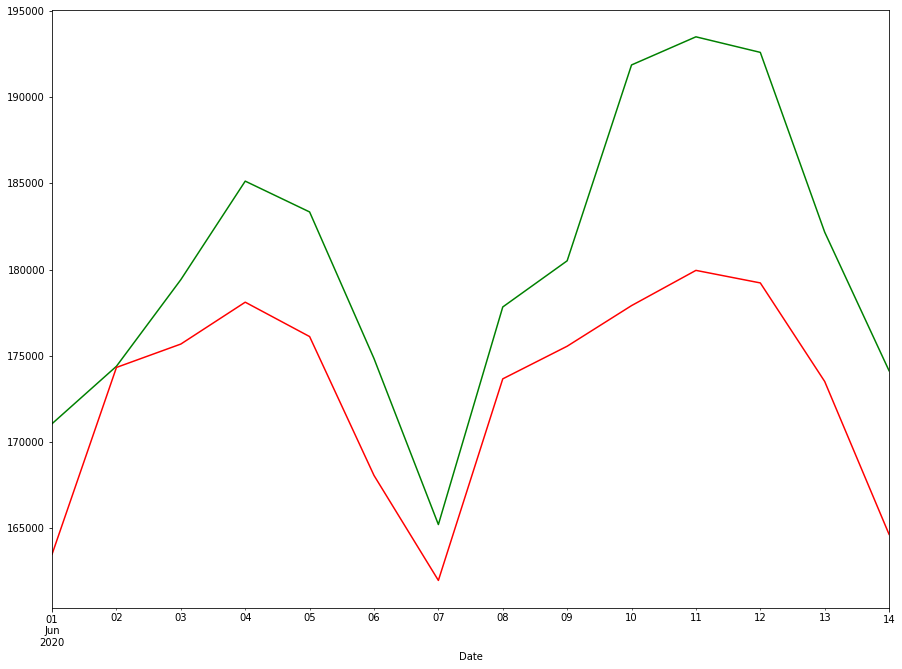

In [96]:
plt.figure(figsize=(15,11))
y_pred.plot(color = 'green')
#y_train.plot(color = 'blue')
y_true.plot(color = 'red')

MAPE_MODEL = mean_absolute_percentage_error(y_true, y_pred) # MAE en pourcentage 
y_baseline = np.ones(N_test)*y_train[-1]
MAPE_baseline = mean_absolute_percentage_error(y_true, y_baseline) # MAE en pourcentage
print(f'MAPE_MODEL = {MAPE_MODEL}, MAPE_baseline = {MAPE_baseline}')

## Cross-validation

In [140]:
#model = RandomForestRegressor() #0.033
#model = GradientBoostingRegressor() #0.033
#model = BaggingRegressor() #0.035
#model = XGBRegressor() #0.035
#model = KNeighborsRegressor() #0.036
#model = DecisionTreeRegressor() #0.046
#model = AdaBoostRegressor() #0.050
#model = LinearRegression() #0.060
# model = baseline #0.066
#model = StackingRegressor(estimators=[('lr', RidgeCV()),('svr', LinearSVR(random_state=42))],final_estimator=RandomForestRegressor()) #0.121
#model = SVR() #0.133

N_test = 14
N_reg=1 #Nombre de jours auto-régressifs

dict_result_model=dict()
dict_result_baseline=dict()

for i in range(0,20):
    Date_debut_test = pd.to_datetime('2020-06-01') + timedelta(days=15)*i
    y_true, y_pred, y_train = compute_energy_forecast(df, Date_debut_test, N_reg,model)
    y_baseline = np.ones(N_test)*y_train[-1]
    dict_result_model[i] = mean_absolute_percentage_error(y_true, y_pred)
    dict_result_baseline[i] = mean_absolute_percentage_error(y_true, y_baseline)

In [141]:
mean = 0
i=0
for value in dict_result_model.values():
    i=i+1
    mean = mean +value
mean = mean/i
mean

0.12127672803381828

In [142]:
mean = 0
i=0
for value in dict_result_baseline.values():
    i=i+1
    mean = mean +value
mean = mean/i
mean

0.06592970433391471